In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
### 라이브러리 불러오기
import pandas as pd
import numpy as np
from lightfm import LightFM
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import random
plt.rc('font', family='NanumBarunGothic')

In [4]:
# 파일불러오기
user = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/user.csv") # 유저 데이터
post = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/post (2).csv", index_col=0) # 채용 공고 데이터
user_post = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/user_post.csv") # 유저와 채용 공고 상호 작용 데이터

In [6]:
# 유저 학점 컬럼 전처리
user['grades'] = pd.to_numeric(user['grades'], errors='coerce') # 숫자 변환
user['grades'].fillna(0, inplace=True) # 결측치 0으로 채우기
user["grades"] = user["grades"].astype(float) # float으로 변환
# 유저 학점 범주화
bins = [0, 1, 3, 4, 4.5] # 1~2는 없음
cuts = pd.cut(user["grades"], bins, right=False)
user["grades"] = cuts
# 인기 게시물 1, 아닌 경우 0
likes = [1, 0]
# popular_yn컬럼 생성
post['popular_yn'] = random.choices(likes, k=len(post), weights=[0.1, 0.9])
# 위 경도 결측치 제거
post.dropna(axis=0, inplace=True)
# 비슷한 위치끼리 KMeans로 묶기
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(post[["latitude", "longitude"]])
post["location_cluster"] = kmeans.labels_
post["location_cluster"] = post["location_cluster"].astype("category")
# 커리어 카테고리형 변환
post["career_id"] = post["career_id"].astype("category")
# post_라는 post에서 쓸 컬럼만 다시 생성
post_ = post.drop(columns=["company","inner_company","latitude","longitude","stack","main_business","qualification", "preferences","title","address","site","date","keywords","weights","embedding"])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [8]:
user.head()

,id,scrapCount,role,university,major,grades,career,activity,Content,embed
0,1,11,DevOps/시스템엔지니어,대졸,컴퓨터공학과,"[3.0, 4.0)",사회생활 경험:,없음,1.코오롱베니트에 지원한 동기와 우리 회사에서 이루고 싶은 목표를 적어주세요.\n\...,1코오롱베니트에 지원한 동기와 우리 회사에서 이루고 싶은 목표를 적어주세요 지원동기...
1,2,16,서버/백엔드,대졸,통계학과,"[3.0, 4.0)",사회생활 경험:,없음,1.지원동기 및 입사 후 목표에 대해 기재해주세요.\n[성장하는 E-commerce...,1지원동기 및 입사 후 목표에 대해 기재해주세요성장하는 의 이끌어 나갈 수 있는 트...
2,3,3,SW/솔루션,대졸,산업공학과,"[3.0, 4.0)",사회생활 경험: 인턴 3회,공모전 수상 3회,kt ds 및 해당 직무에 지원한 동기와 입사 후 해당 직무의 전문가로 성장하기 위...,및 해당 직무에 지원한 동기와 입사 후 해당 직무의 전문가로 성장하기 위해 어떠...
3,4,21,게임/VR/AR/3D,대졸,비전공,"[4.0, 4.5)",사회생활 경험: SGI서울보증 계약직 1년,없음,1. 넥슨과 선택하신 직무에 지원하신 동기와 입사 후 성장 목표를 서술해주세요.\n...,1 넥슨과 선택하신 직무에 지원하신 동기와 입사 후 성장 목표를 서술해주세요넥슨의 ...
4,5,21,게임/VR/AR/3D,대졸,비전공,"[4.0, 4.5)",사회생활 경험: SGI서울보증 계약직 1년,없음,1. 넥슨과 선택하신 직무에 지원하신 동기와 입사 후 성장 목표를 서술해주세요.\n...,1 넥슨과 선택하신 직무에 지원하신 동기와 입사 후 성장 목표를 서술해주세요넥슨의 ...


In [9]:
def get_user_graph(column_name, title_name):
  '''
  column_name: 컬럼 변수
  유저 그래프 시각화
  '''
  series = user[column_name].value_counts(ascending=False)
  print(series)
  sns.barplot(x=series.index, y=series.values, palette='husl')
  plt.title(title_name)
  plt.xlabel(title_name)
  plt.xticks(rotation=45)
  plt.ylabel(column_name)
  plt.show()
def get_post_graph(column_name, title_name):
  '''
  채용공고 시각화
  '''
  series = post[column_name].value_counts(ascending=False)
  print(series)
  sns.barplot(x=series.index, y=series.values, palette='husl')
  plt.title(title_name)
  plt.xlabel(title_name)
  plt.xticks(rotation=45, ha='right',fontsize=12)
  plt.ylabel(column_name)
  plt.show()

SW/솔루션            118
DevOps/시스템엔지니어     46
인공지능/머신러닝          31
서버/백엔드             11
프론트엔드               4
모바일                 4
QA                  4
DBA                 3
게임/VR/AR/3D         2
웹풀스택                2
Name: role, dtype: int64


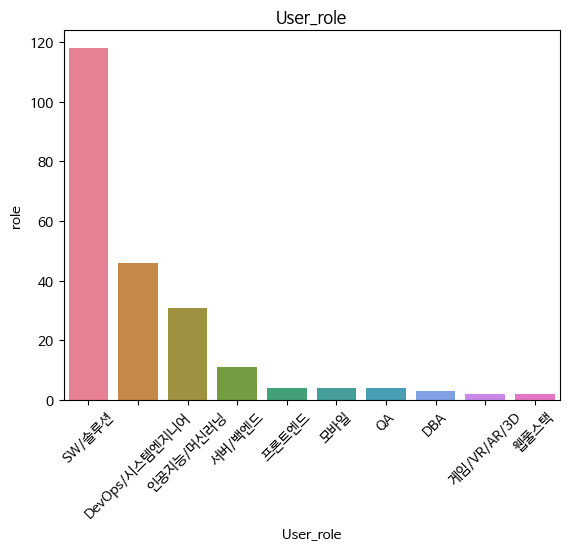

In [10]:
get_user_graph("role","User_role")

대졸    206
고졸     10
석사      9
Name: university, dtype: int64


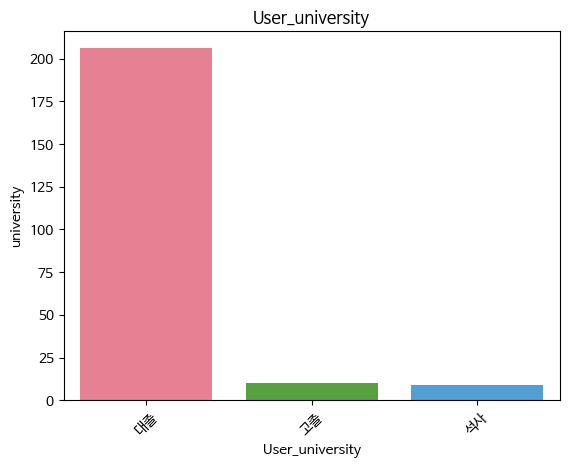

In [11]:
get_user_graph("university","User_university")

비전공         115
컴퓨터공학과       70
정보통신학과       16
산업공학과        10
통계학과          9
소프트웨어공학과      5
Name: major, dtype: int64


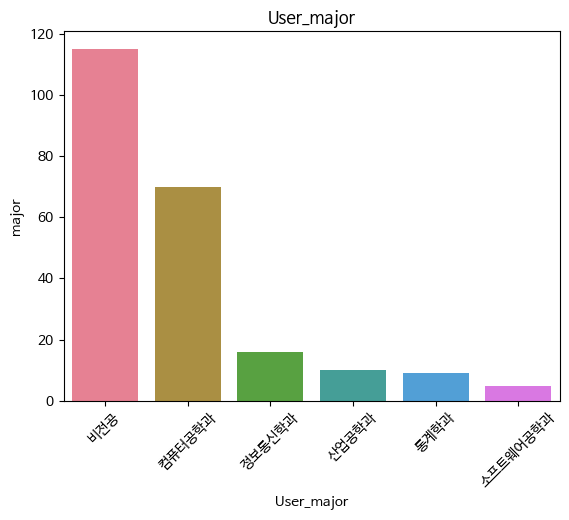

In [12]:
get_user_graph("major","User_major")

[3.0, 4.0)    157
[4.0, 4.5)     35
[0.0, 1.0)     25
[1.0, 3.0)      7
Name: grades, dtype: int64


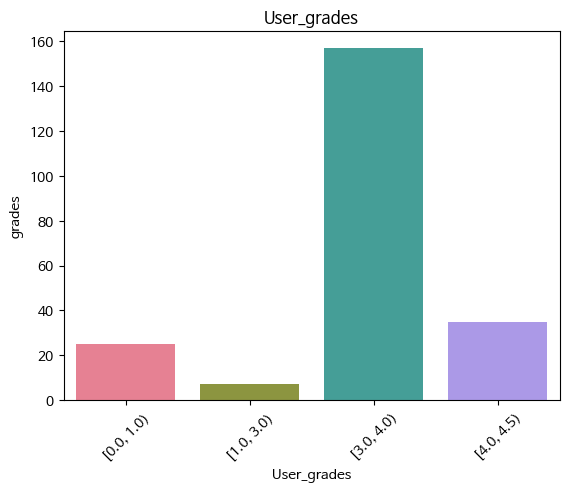

In [13]:
get_user_graph("grades","User_grades")

In [14]:
### 채용공고 확인

In [15]:
post.head()

,id,company,position,title,stack,main_business,qualification,preferences,career_id,site,...,material,microsoftoutlook,microsoftsharepoint,websphere,redhatenterpriselinux,rhcsa,trello,blueprint,popular_yn,location_cluster
0,1,아나토마지코리아,SW/솔루션,[외국계] C++/Windows Application Product Develope...,"c++,python,image processing,vtk,mfc,opengl",C++/Windows Application Product Developer (C++...,[자격 사항]\n\n• 3년 이상의 어플리케이션 개발 경력이 있으신 분\n• C++...,[우대 사항]\n\n• C++외에 Python등의 스크립트 언어 개발 경험이 있으신...,4,https://career.programmers.co.kr/job_positions...,...,0,0,0,0,0,0,0,0,0,2
1,2,아나토마지코리아,SW/솔루션,[외국계] C++/Windows Application Algorithm Develo...,"c++,openmp,python,image processing,vtk,mfc,opengl",C++/Windows Application Algorithm Developer (C...,[자격 사항]\n• 3년 이상의 어플리케이션 및 알고리즘 개발 경력이 있으신 분 •...,[우대 사항]\n• 데이터 처리 효율화를 위한 병렬처리 관련 개발 경험이 있으신 분...,4,https://career.programmers.co.kr/job_positions...,...,0,0,0,0,0,0,0,0,0,2
2,3,아나토마지코리아,인공지능/머신러닝,[외국계] Machine Learning Engineer(머신러닝 엔지니어),"pytorch,tensorflow,scikit-learn,c++,python,ima...",Machine Learning Engineer(머신러닝 엔지니어) 모집\n\n[업무...,[자격 사항]\n• 3년 이상의 머신러닝/이미지 프로세싱/3차원 데이터 프로세싱 알...,"[우대 사항]\n• 머신러닝, 딥러닝을 이용한 알고리즘 개발 및 제품화 경험이 있으...",4,https://career.programmers.co.kr/job_positions...,...,0,0,0,0,0,0,0,0,0,2
3,4,아나토마지코리아,인공지능/머신러닝,[외국계] Machine Learning Engineer(머신러닝 엔지니어),"pytorch,tensorflow,scikit-learn,c++,python,ima...",Machine Learning Engineer(머신러닝 엔지니어) 모집\n\n[업무...,[자격 사항]\n• 3년 이상의 머신러닝/이미지 프로세싱/3차원 데이터 프로세싱 알...,"[우대 사항]\n• 머신러닝, 딥러닝을 이용한 알고리즘 개발 및 제품화 경험이 있으...",4,https://career.programmers.co.kr/job_positions...,...,0,0,0,0,0,0,0,0,0,2
4,5,아나토마지코리아,데이터엔지니어,[외국계] Machine Learning Engineer(머신러닝 엔지니어),"pytorch,tensorflow,scikit-learn,c++,python,ima...",Machine Learning Engineer(머신러닝 엔지니어) 모집\n\n[업무...,[자격 사항]\n• 3년 이상의 머신러닝/이미지 프로세싱/3차원 데이터 프로세싱 알...,"[우대 사항]\n• 머신러닝, 딥러닝을 이용한 알고리즘 개발 및 제품화 경험이 있으...",4,https://career.programmers.co.kr/job_positions...,...,0,0,0,0,0,0,0,0,0,2


4     1400
1      907
3      782
6      624
2      393
5      180
8      123
9       55
7       50
11      42
10       3
12       2
13       1
Name: career_id, dtype: int64


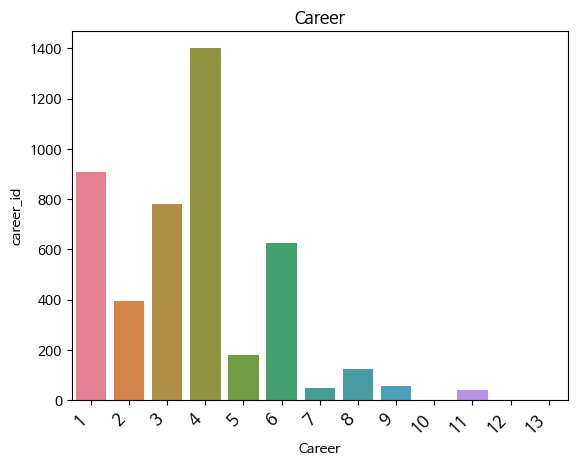

In [16]:
get_post_graph("career_id","Career")
# 1: 신입 이상 / 2: 1년 이상 / 3: 2년 이상 ...

SW/솔루션            624
서버/백엔드            584
모바일               526
DevOps/시스템엔지니어    485
프론트엔드             420
인공지능/머신러닝         408
웹풀스택              302
게임/VR/AR/3D       242
데이터엔지니어           205
임베디드              196
개발PM              116
블록체인              108
QA                103
인터넷보안              85
기술지원               85
DBA                73
Name: position, dtype: int64


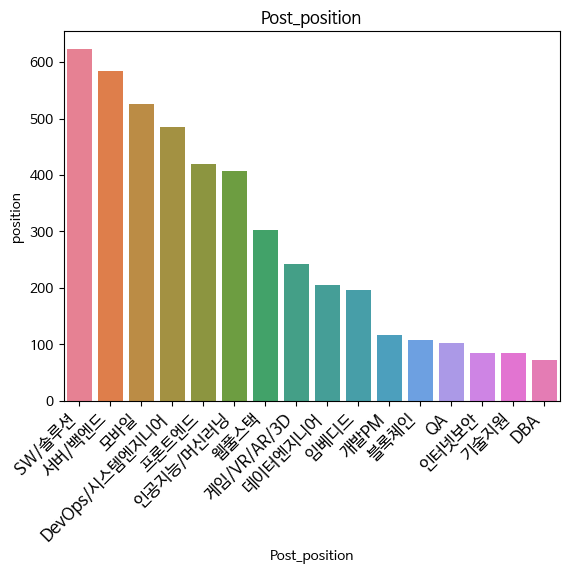

In [21]:
get_post_graph("position","Post_position")

0    4094
1     468
Name: popular_yn, dtype: int64


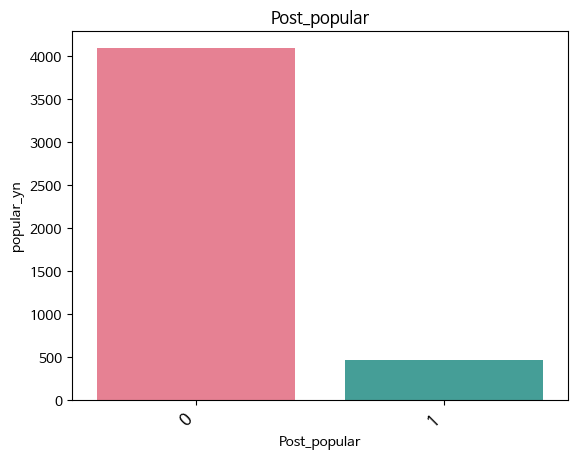

In [17]:
get_post_graph("popular_yn","Post_popular")

위메이드          96
오케스트로         51
인터엑스          48
페이타랩          40
엔에이치엔크로센트     39
펜타시큐리티시스템     37
쿤텍            36
리디            32
Coupang       31
해줌            26
넛지헬스케어        25
앤서스랩코리아       23
슈어소프트테크       21
덴티움           20
알피니언메디칼시스템    20
한국딥러닝         19
인젠트           19
로민            19
라온시큐어         18
뉴빌리티          18
Name: company, dtype: int64


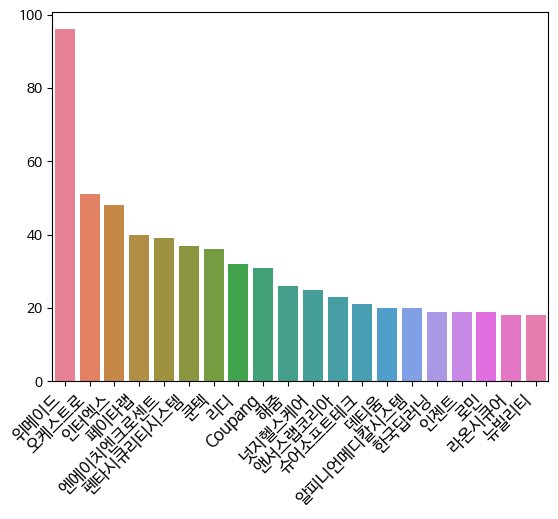

In [18]:
### 채용 공고 데이터 중 가장 많이 채용하고 있는 회사
company = post['company'].value_counts()[:20]
print(company)
sns.barplot(x=company.index, y=company.values, palette='husl') # pallete: 색상 팔레트 지정
plt.xticks(rotation=45, ha='right', fontsize=12) # ha: 레이블의 정렬 방향
plt.show()

서울 강남구        1386
서울 서초구         545
경기 성남시 분당구     446
서울 영등포구        276
서울 성동구         187
서울 송파구         176
서울 마포구         176
경기 성남시 수정구     155
서울 금천구         152
서울 중구          143
서울 구           108
경기 안양시 동안구      73
서울 강서구          73
서울 종로구          72
대전 유성구          63
서울 관악구          37
경기 수원시 영통구      32
울산 중구           31
서울 용산구          29
경기 용인시 수지구      28
Name: address, dtype: int64


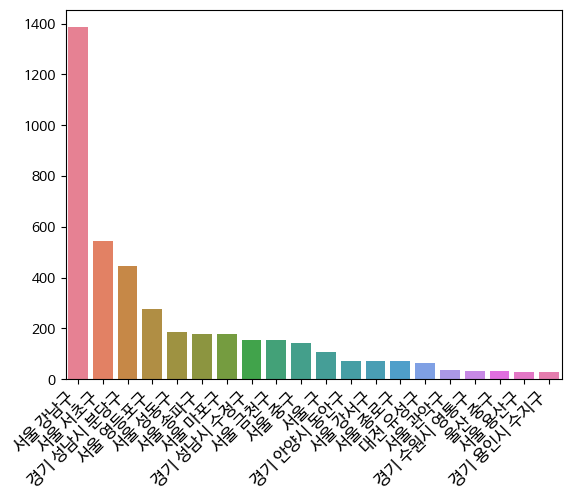

In [19]:
# IT기업 중 가장 많이 있는 회사들의 위치
addresses = post['address'].apply(lambda x: x.split("구")[0]+"구").value_counts()[:20]
print(addresses)
sns.barplot(x=addresses.index, y=addresses.values, palette='husl')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

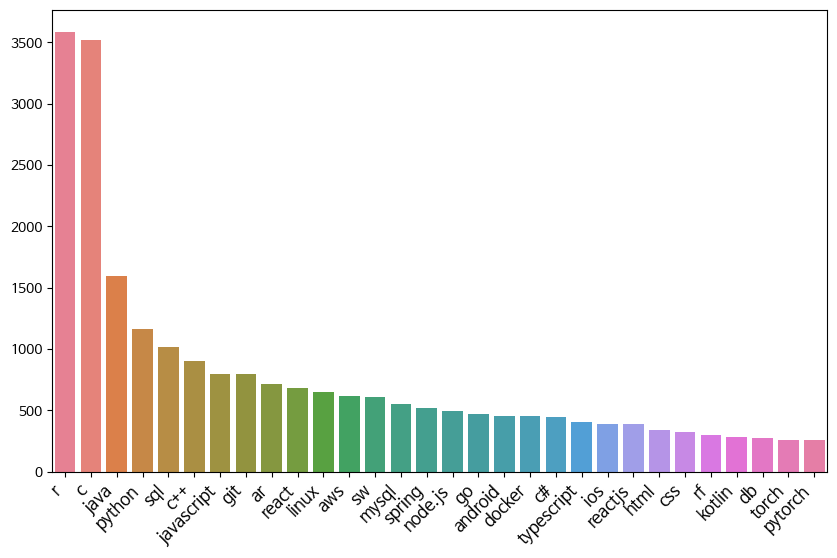

In [30]:
# 채용 공고 회사들 중 요구하고 있는 상위 스택
result = post.iloc[:,18:-2].sum().sort_values(ascending=False)[:30]
plt.figure(figsize=(10,6))
# 막대 그래프 그리기
sns.barplot(x=result.index, y=result.values, palette='husl')

# x축 레이블 크기 조절
plt.xticks(rotation=45, ha='right', fontsize=12)

plt.show()

In [62]:
def get_stack_with():
  '''
  해당 스택과 같이 많이 쓰이는 스택들 보여주기
  '''
  result = post.iloc[:,18:-2].sum().sort_values(ascending=False)[:50]
  print(f"가장 많이 쓰이는 스택들은 \n{result}입니다. \n이 중 하나를 골라주세요")
  stack = input()
  df = post.iloc[:,18:-2]
  rows = df[df[stack] == 1].drop(stack,axis=1)
  sums = rows.sum(numeric_only=True).sort_values(ascending=False)[:10] # numeric_only: 숫자 컬럼만 지정
  plt.pie(sums.values, labels = sums.index, autopct='%1.1f%%')
  plt.show()

가장 많이 쓰이는 스택들은 
r             3586
c             3522
java          1592
python        1160
sql           1014
c++            906
javascript     796
git            796
ar             714
react          679
linux          647
aws            617
sw             609
mysql          555
spring         516
node.js        494
go             474
android        456
docker         454
c#             443
typescript     409
ios            393
reactjs        390
html           337
css            323
rf             296
kotlin         282
db             274
torch          263
pytorch        258
dtype: int64입니다. 
이 중 하나를 골라주세요
c++


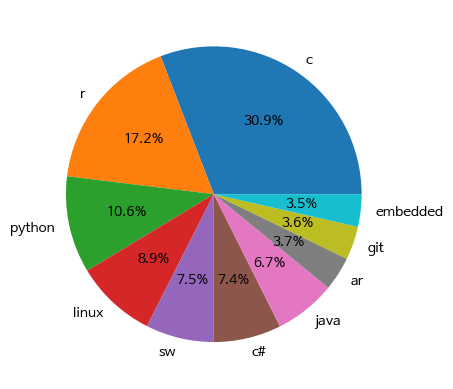

In [41]:
get_stack_with()

## 모델링

In [43]:
# user_post 데이터 중 post_ID에 있는 post_ID 걸러내기
user_post = user_post[user_post['post_ID'].isin(post['id'])]
user_post.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120032 entries, 0 to 121806
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_ID            120032 non-null  int64  
 1   post_ID            120032 non-null  int64  
 2   Cosine Similarity  120032 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.7 MB


In [44]:
# Cosine_similarity 컬럼의 값을 평점과 곱하기
user_post['Cosine Similarity'] *= np.random.randint(1, 6, size=len(user_post))

In [45]:
# user_post 코사인 유사도를 반올림
import math
user_post["Cosine Similarity"] = user_post["Cosine Similarity"].apply(lambda x: round(x) / 10 * 10)
# int로 변환
user_post["user_ID"] = user_post["user_ID"].astype(int)
user_post["post_ID"] = user_post["post_ID"].astype(int)
user_post["Cosine Similarity"] = user_post["Cosine Similarity"].astype(int)

3    27062
2    26703
4    26522
1    25178
5    14435
0      132
Name: Cosine Similarity, dtype: int64


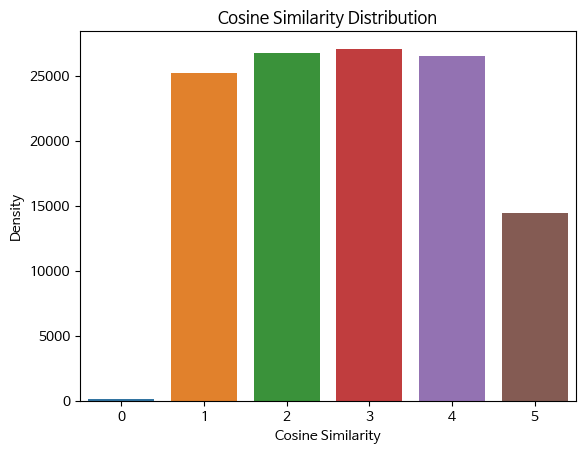

In [46]:
# 등급 분포확인
print(user_post["Cosine Similarity"].value_counts())
sns.countplot(data=user_post, x='Cosine Similarity')
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.show()

In [47]:
# User 데이터프레임: user
# - ID 컬럼: ID
# - 피처 컬럼들: role, university, major, grades

# Item 데이터프레임: post
# - ID 컬럼: id
# - 피처 컬럼들: Label, stack들, Career, location_cluster

# 상호작용 데이터프레임 (코사인 유사도): user_post
# - User ID 컬럼: user_ID
# - Item ID 컬럼: post_ID
# - 코사인 유사도 값 컬럼: Cosine Similarity

### 유저 피쳐 데이터 준비

In [48]:
user = pd.get_dummies(user[["id","role","university","major","grades"]])
user_features_col = user.drop(columns =['id']).columns.values
user_feat = user.drop(columns =['id']).to_dict(orient='records')

user.head()

,id,role_DBA,role_DevOps/시스템엔지니어,role_QA,role_SW/솔루션,role_게임/VR/AR/3D,role_모바일,role_서버/백엔드,role_웹풀스택,role_인공지능/머신러닝,...,major_비전공,major_산업공학과,major_소프트웨어공학과,major_정보통신학과,major_컴퓨터공학과,major_통계학과,"grades_[0.0, 1.0)","grades_[1.0, 3.0)","grades_[3.0, 4.0)","grades_[4.0, 4.5)"
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,4,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


## 채용 공고 데이터 준비

In [49]:
item = pd.get_dummies(post_)
item_features_col = item.drop(columns=['id']).columns.values
item_feat = item.drop(columns =['id']).to_dict(orient='records')

item.head()

,id,java,javascript,jquery,postgresql,mysql,restapi,linux,spring,node.js,...,career_id_9,career_id_10,career_id_11,career_id_12,career_id_13,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 유저와 채용 공고, 유저 피쳐, 채용 공고 피쳐를 LightFM 데이터셋 객체에 매핑하기

In [50]:
from lightfm.data import Dataset
dataset = Dataset()
dataset.fit(users=[x for x in user['id']], items=[x for x in item['id']], item_features=item_features_col, user_features=user_features_col)

num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 225, num_items 4562.


### 모델에 채용공고 피쳐 빌드하기

In [51]:
item_features = dataset.build_item_features((x,y) for x,y in zip(item['id'],item_feat))

### 모델에 유저 피쳐 빌드하기

In [52]:
user_features = dataset.build_user_features((x,y) for x,y in zip(user['id'],user_feat))

## 유저와 채용 공고 간의 상호 작용, 가중치 빌드하기

In [53]:
(interactions, weights) = dataset.build_interactions((x, y, z)
                                                   for x,y,z in zip(user_post['user_ID'], user_post['post_ID'], user_post['Cosine Similarity']))

### train, test 분리하기

In [54]:
from lightfm.cross_validation import random_train_test_split

train, test = random_train_test_split(interactions,test_percentage=0.25, random_state=42)
train_w, test_w = random_train_test_split(weights, test_percentage=0.25, random_state=42)

## 모델 만들기

In [55]:
# no_components: 사용자 및 항목 임베딩의 차원을 결정합니다. 이 값을 늘리면 데이터에서 더 복잡한 관계를 캡처할 수 있지만 모델의 복잡성과 훈련 시간도 증가합니다.
# item_alpha 및 user_alpha: 각각 항목 및 사용자 임베딩에 적용되는 정규화 강도를 제어합니다. 정규화는 모델이 개별 기능에 과도한 중요성을 할당하지 않도록 하여 과적합을 방지하는 데 도움이 됩니다. 이 값을 조정하면 적용되는 정규화의 양을 제어할 수 있습니다.
# 'alpha': item-feature 및 user-feature 매트릭스에 적용되는 스케일링 계수를 결정합니다. '알파' 값이 높을수록 기능 매트릭스의 영향력이 증가하고 값이 낮을수록 사용자와 항목 간의 상호 작용에 더 많은 가중치를 부여합니다.
# max_sampled 매개변수를 사용하면 각 학습 반복에서 사용되는 최대 네거티브 샘플 수를 제어할 수 있습니다. max_sampled에 더 낮은 값을 설정하면 모델 교육의 계산 비용을 줄일 수 있습니다. 그러나 너무 낮게 설정하면 과소적합 및 모델 매개변수 학습이 불충분할 수 있습니다.

In [ ]:
n_components = 50
loss = 'warp'
epoch = 30
num_thread = 4
model = LightFM(no_components= n_components, learning_rate=0.03,loss=loss, random_state = 42, user_alpha=1e-3, item_alpha=1e-4)
model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w, verbose=True)

Epoch: 100%|██████████| 30/30 [24:08<00:00, 48.27s/it]


## 피클 사용하여 모델 저장하기

In [ ]:
import pickle
# 모델 저장
with open('/content/drive/MyDrive/model_Recomendation_Last', 'wb') as f:
    pickle.dump(model, f)

In [60]:
import pickle
# 모델 저장
#with open('model_Recomendation', 'wb') as f:
 #     pickle.dump(model, f)
# 모델 불러오기
with open('/content/drive/MyDrive/model_Recomendation_Last', 'rb') as f:
     model = pickle.load(f)

## 모델 평가하기 AUC_SCORE

In [61]:
train_precision = precision_at_k(model, train, k=10,item_features=item_features, user_features=user_features).mean()
test_precision = precision_at_k(model, test,train_interactions=train, k=10,item_features=item_features, user_features=user_features).mean()

train_recall = recall_at_k(model, train, k=10,item_features=item_features, user_features=user_features).mean()
test_recall = recall_at_k(model, test,train_interactions=train, k=10,item_features=item_features, user_features=user_features).mean()

train_auc = auc_score(model, train,item_features=item_features, user_features=user_features).mean()
test_auc = auc_score(model, test, train_interactions=train,item_features=item_features, user_features=user_features).mean()

print('Precision: train %.4f' % (train_precision))
print('Precision: test %.4f' % (test_precision))

print('Recall: train %.4f' % (train_recall))
print('Recall: test %.4f' % (test_recall))

print('AUC: train %.4f' % (train_auc))
print('AUC: test %.4f' % (test_auc))

Precision: train 0.7915
Precision: test 0.9866
Recall: train 0.0214
Recall: test 0.0800
AUC: train 0.9783
AUC: test 0.9933


## 추천하기

## 샘플 유저에 대해 예측하여 추천하기 3은 lightfm model index이므로 실제 user_id는 4

In [63]:
scores = model.predict(3, np.arange(interactions.shape[1]))
top_items = post.iloc[np.argsort(-scores)]
known_positives = post.iloc[interactions.tocsr()[3].indices]
top_items[0:10][['title','inner_company']]

,title,inner_company
2975,HTML5 웹 게임 개발자 채용,엔포트버스
339,[전기아이피] 백엔드 개발,위메이드
883,Senior 3D Engine Engineer,레드브릭
750,게임 서버 개발자,111퍼센트
957,[AR]Computer Vision Engineer,알비언
1086,[캐주얼게임] 클라이언트 엔지니어,로드컴플릿
1065,백엔드 개발자,엔스테이지
4505,Senior 3D Engine Engineer (5년 이상),레드브릭
2605,주니어 백엔드 개발자,베이글코드
2956,[골프존] 클라이언트 개발자 (모바일게임),골프존


## 아이템 피쳐로부터 비슷한 아이템 뽑아주기

In [64]:
def similar_items(item_id, model, N=10, norm = True):
    # item_id = 아이템 아이디, model = 모델
    # 아이템의 편향과 표현 모델에서 가져오기
    item_bias ,item_representations = model.get_item_representations(features=item_features)

    scores = item_representations.dot(item_representations[item_id, :])
    item_norms = np.linalg.norm(item_representations, axis=1)
    # 편향 정규화 여부
    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]/ item_norms[item_id] ), key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] ), key=lambda x: -x[1])
    similar_idx = [x[0] for x in similar]
    return post.iloc[similar_idx][['title',"inner_company"]]

In [66]:
similar_items(1010, model)

,title,inner_company
1034,데이터 엔지니어(Data Engineer),플루토랩스
3142,Data Engineer(2년 이상),크레버스 강남
3121,서버 백엔드 개발,이글루코퍼레이션
2265,[Coupang] Staff Backend Engineer (Data Infra/ ...,Coupang
1244,백엔드 개발자 (Backend Developer),메이아이
1761,Senior Data Engineer,트릿지
1912,[쿠팡]비즈니스 데이터 분석가,Coupang
1692,빅데이터/머신러닝 개발자,누리어시스템
4565,솔루션 엔지니어 / IT 성능 컨설턴트,와탭랩스
3790,"[패스오더] 백엔드 개발자(Spring, Python, MSA)",페이타랩


## 비슷한 유저 뽑아주기

In [67]:
def similar_users(user_id, model, N=10, norm = True):
    # user_id와 model 입력, 비슷한 유저 아이디 반환
    # 유저 편향, 표현 가져오기
    user_bias ,user_representations = model.get_user_representations(features= user_features)

    scores = user_representations.dot(user_representations[user_id, :])
    item_norms = np.linalg.norm(user_representations, axis=1)

    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] / item_norms[user_id]),
                    key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]),
                    key=lambda x: -x[1])
    similar_idx = [x[0] for x in similar]
    return user[user['id'].isin(similar_idx)]['id']

In [68]:
#similar_item_list =
similar_users(5,model)
#similar_idx = [x[0] for x in similar_item_list]
#cols = ['id', 'major_컴퓨터공학과', 'university_대졸', 'grades_[3.0, 4.0)']
#user[user['id'].isin(similar_idx)].loc[:,cols]

4        5
75      76
106    107
107    108
156    157
175    176
177    178
186    187
195    196
218    219
Name: id, dtype: int64

## 추천 결과 보여주기



## 새로운 유저 추천

In [69]:
def get_top_items_for_user_input(model, post, n=10):
    '''
    model: 모델 객체
    post: 채용 공고 데이터
    '''
    # 유저 피쳐
    user_features_col = np.array(['role_DBA', 'role_DevOps/시스템엔지니어', 'role_QA', 'role_SW/솔루션',
       'role_게임/VR/AR/3D', 'role_모바일', 'role_서버/백엔드', 'role_웹풀스택',
       'role_인공지능/머신러닝', 'role_프론트엔드', 'university_고졸', 'university_대졸',
       'university_석사', 'major_비전공', 'major_산업공학과', 'major_소프트웨어공학과',
       'major_정보통신학과', 'major_컴퓨터공학과', 'major_통계학과', 'grades_[0.0, 1.0)',
       'grades_[1.0, 3.0)', 'grades_[3.0, 4.0)', 'grades_[4.0, 4.5)'])
    # 현재 학습시킨 유저 포지션, 학력, 전공, 학점 라벨
    roles_labels = ["DBA","DevOps/시스템엔지니어","QA","SW/솔루션","게임/VR/AR/3D","모바일","서버/백엔드","웹풀스텍","인공지능/머신러닝","프론트엔드"]
    unv_labels = ["고졸","대졸","석사"]
    major_labels = ["비전공","산업공학과","소프트웨어공학과","정보통신학과","컴퓨터공학과","통계학과"]
    grades_bins = ["[0.0, 1.0)","[1.0, 3.0)","[3.0, 4.0)","[4.0, 4.5)"]
    print("다음 라벨 중 입력할 유저의 피쳐를 입력하세요\n",roles_labels,"\n",unv_labels,"\n",major_labels,"\n",grades_bins)
    # 입력받기
    role = input("포지션: ")
    unv = input("학력: ")
    major = input("전공: ")
    grades = input("학점: ")

    # 새로운 유저 0으로 초기화
    new_user = pd.DataFrame(np.zeros(len(user_features_col))).T
    new_user.columns = user_features_col

    # 유저 피쳐 입력
    new_user[f'role_{role}'] = 1
    new_user[f'university_{unv}'] = 1
    new_user[f'major_{major}'] = 1
    new_user[f'grades_{grades}'] = 1
    new_user = csr_matrix(new_user)

    # 새로운 유저 예측하기
    scores_new_user = model.predict(user_ids=0, item_ids=np.arange(len(post)), user_features=new_user)

    # 상위 n개 채용 공고 추천해주기
    top_items_new_user = post.iloc[np.argsort(-scores_new_user)][:n]

    return top_items_new_user[['id','inner_company', 'title']]

In [70]:
top_items = get_top_items_for_user_input(model, post, n=10)
print(top_items)

다음 라벨 중 입력할 유저의 피쳐를 입력하세요
 ['DBA', 'DevOps/시스템엔지니어', 'QA', 'SW/솔루션', '게임/VR/AR/3D', '모바일', '서버/백엔드', '웹풀스텍', '인공지능/머신러닝', '프론트엔드'] 
 ['고졸', '대졸', '석사'] 
 ['비전공', '산업공학과', '소프트웨어공학과', '정보통신학과', '컴퓨터공학과', '통계학과'] 
 ['[0.0, 1.0)', '[1.0, 3.0)', '[3.0, 4.0)', '[4.0, 4.5)']
포지션: 서버/백엔드
학력: 대졸
전공: 소프트웨어공학과
학점: [3.0,4.0)
        id inner_company                                    title
500    501           우리요                               서버/백엔드 개발자
2380  2381           트위니    자율 주행 로봇 플랫폼 백엔드 개발자 (전문연구요원, 판교근무가능)
4288  4289          플래티어                        그루비사업부 마케팅 솔루션 개발
4243  4244        케이티넥스알         [kt NexR] Technical Architect 채용
983    984         코코네 엠  SRE 엔지니어 (Site Reliability Engineering)
1529  1530          인라이플           Backend_Developer (JAVA) 웹 개발자
4174  4175    슈어소프트테크 대전                   C# 개발자 (시뮬레이션개발팀) - 대전
2459  2460           브리치                            프론트엔드&백엔드 개발자
4372  4373       한국알박 성남                  Software개발(Database) 채용
968    969     에이블리코퍼레이션